How to use GridSearch with Neural Network:

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Metrics that I need to implement:

https://www.kdnuggets.com/2018/04/right-metric-evaluating-machine-learning-models-1.html

In [ ]:
!pip install arff
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
import math
import json

# **Opening the data set**

The data set is loaded from a CSV file named "meteorological_data" that I created and cleaned in my other python file. Check out "generateData" to obtain more information about.

In [ ]:
dataFrame=pd.read_csv('meteorological_data.csv')

dataFrame['mes'] = [dataFrame['data completa'][index][5:7] for index in range( len(dataFrame['data completa']) )]

display(dataFrame)
#display(dataFrame['data completa'][0][6])

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,estacao_id,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO,mes
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,0.0,49,2003-02-18,28.15,2.815185,2.158130,02
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,0.0,50,2003-02-19,27.90,4.412632,4.312026,02
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,0.0,51,2003-02-20,25.85,2.939072,3.032922,02
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,0.0,52,2003-02-21,26.40,4.719712,4.768149,02
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,0.0,53,2003-02-22,27.70,4.333662,4.317706,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,15.0,339,2019-12-05,34.25,4.155351,3.864984,12
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,15.0,341,2019-12-07,36.15,3.246348,2.578275,12
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,15.0,342,2019-12-08,32.15,4.138430,3.941287,12
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,15.0,343,2019-12-09,30.85,5.009957,4.618717,12


In [ ]:
param_grid = {
    'learning_rate':[0.001, 0.01, 0.08],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':[
                       #['RADIACAO GLOBAL(Kj/m²)'],
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ],
    'epochs':[10,40,80,120,160],
    'data_date':['2010-02-11','2013-02-11','2015-02-11']
    }
parameters=list(ParameterGrid(param_grid))
display(len(parameters))

90

# **Class and methods used**

This section contains all methods and classes necessary to perform the evapotranspiration predictions by neural network and evaluation of their results. Most functions and methods names are self-explanatory.

In [ ]:
#from tensorflow.python.keras.utils.version_utils import ModelVersionSelector
class Neural_test:

  def __init__(self,dataframe,drop_columns):

    self.data=dataFrame.drop(labels=drop_columns,axis=1)
  
  def splitting_data(self,date,name_empirical_model):

    #Split the data into training and test based on the data dates.
    #The data dated between 2010-02-18 and 2019-01-01 from each weather station 
    #goes to the training set and the rest goes to the test set.
    #the manner to divide data depends on context.
    #In this situation, the Eo can be more easily predicted using future data,
    #causing a methodological error. So you need to split the data that way.

    empirical_model=[]
    self.data['data completa'] = pd.to_datetime(self.data['data completa'])
    self.data = self.data.set_index(self.data['data completa'])
    self.data = self.data.sort_index()
    
    self.train_dataset = self.data[date[0]:date[1]]
    self.test_dataset  = self.data[date[2]:]
   
    self.test_date=self.test_dataset.index

    self.train_labels = self.train_dataset.loc[:,'Eo_FAO']
    self.test_labels = self.test_dataset.loc[:,'Eo_FAO']

    self.empirical_model=self.test_dataset.loc[:,name_empirical_model]

    self.train_dataset=self.train_dataset.drop(labels=name_empirical_model,axis=1)
    self.test_dataset=self.test_dataset.drop(labels=name_empirical_model,axis=1)

    self.estacao_id = self.test_dataset['estacao_id']
    self.mes = self.test_dataset['mes']

    self.train_dataset=self.train_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes'],axis=1)
    self.test_dataset=self.test_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes'],axis=1)


  def standardize_data(self):

    scaler = StandardScaler()

    scaler.fit(self.train_dataset)
    self.normed_train_data=pd.DataFrame(scaler.transform(self.train_dataset))
    scaler.fit(self.test_dataset)
    self.normed_test_data=pd.DataFrame(scaler.transform(self.test_dataset))

  def get_train(self):
    return self.train_dataset

  def Model(self,Loss,Metrics,activation_function,Learning_rate):

    #This method creates the neural network model with 2 intermediate layers, 5 neurons in each layer and 
    #the other parameters are going to received through function argument defined by the user.

    initializer = tf.keras.initializers.HeNormal(seed=1)

    model = keras.Sequential([
    layers.Dense(5, activation=activation_function, input_shape=[len(self.normed_train_data.keys())],kernel_initializer=initializer),
    layers.Dense(5, activation=activation_function,kernel_initializer=initializer),
    layers.Dense(1)
    ])

    #for layer in model.layers:
    #  a,b = layer.get_weights()[0].shape
    #  layer.set_weights([np.full(shape=(a,b),fill_value=0.5), np.zeros(layer.get_weights()[1].shape)])
    #model.layers[0].set_weights([weights,[0.5,0.5,0.5,0.5,0.5]])
    #display(model.layers[0].get_weights()[0])
    #display(model.layers[0].get_weights()[1])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=Learning_rate)
    
    model.compile(loss=Loss,
                optimizer=optimizer,
                metrics=Metrics
                )
    
    self.model=model
    
  def Fit(self,Epochs,Validation_split,Verbose,show_history=True):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
    
    history = self.model.fit(
    x=self.normed_train_data,
    y=self.train_labels,
    validation_split=Validation_split,
    verbose=Verbose,
    epochs=Epochs
    #callbacks=[es]
    )

    if show_history:
      historico = pd.DataFrame(history.history)
      historico['epoch'] = history.epoch
      display(historico.tail())

    return history
    
  def prediction(self):

    self.prediction_test = self.model.predict(self.normed_test_data).flatten()
    self.prediction_test=pd.Series(self.prediction_test)
  
  def compare(self,limit,show=False):
    
    [test_labels,empirical_model]=[self.test_labels,self.empirical_model]
    #print(self.prediction_test,empirical_model)
    
    if show:
      plt.plot(test_labels[0:limit].reset_index(drop=True),test_labels[0:limit].reset_index(drop=True))
      plt.plot(test_labels[0:limit].reset_index(drop=True),self.prediction_test[0:limit],'x')
      plt.plot(test_labels[0:limit].reset_index(drop=True),empirical_model[0:limit],'x')
      plt.ylabel('Rede Neural')
      plt.xlabel('Fao 56')
      #plt.plot(previsoes_teste[0:50])
      plt.savefig('grap.png')
      plt.show()

    r2=r2_score(test_labels, self.prediction_test)
    #r2_2=r2_score(test_labels, empirical_model)
    print(r2)
    return r2


def convert_excel_to_dict(excel,qtd):
  dataset = dict()

  for id in range(len(excel)-1,len(excel)-1-qtd,-1):
    
    dataset[str(id)] = dict()
    json_data = json.loads(excel[id].replace("'",'"'))
    dataset[str(id)]['parameters'] = json_data['parameters']
    dataset[str(id)]['result'] = json_data['result']
  
  return dataset

def get_results(parameters):
  
  [index,simulation_result,keys] = [0,dict(),['parameters','result','id','history']]

  for key in keys:
    simulation_result[key] = [] 

  #condition = parameters['data_date'][0]

  for parameter in parameters:

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date']+'\n')
    neural_network = Neural_test(dataFrame,parameter['features_delete'])
    neural_network.splitting_data([parameter['data_date'],'2019-01-01','2019-01-02'],['Eo_samani'])
    neural_network.standardize_data()
    
    neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
    
    history = neural_network.Fit(parameter['epochs'],0.2,0,True)
    
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    
    simulation_result['parameters'].append(parameter) 
    simulation_result['id'].append(index)
    simulation_result['result'].append(coeficent)
    simulation_result['history'] = history
    print(index)
    index+=1

  return simulation_result

def Creating_result_table(results_dict):

  matrix = []

  for id in results_dict:
    matrix.append([results_dict[str(id)]['parameters']['data_date'],results_dict[str(id)]['parameters']['epochs'],len(results_dict[str(id)]['parameters']['features_delete']),results_dict[str(id)]['parameters']['learning_rate'],results_dict[str(id)]['result']])
  
  matrix = pd.DataFrame(matrix).rename(columns={0:'Data de inicio',1:'épocas',2:'features deletadas',3:'taxa de aprendizagem',4:'coeficiente de determinação'})
  
  return matrix

def make_prediction(dataFrame,parameter):

  neural_network = Neural_test(dataFrame,parameter['features_delete'])  
  neural_network.splitting_data([parameter['data_date'],'2019-01-01','2019-01-02'],['Eo_samani'])
  neural_network.standardize_data()
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
    
  history = neural_network.Fit(parameter['epochs'],0.2,0,False)

  neural_network.prediction()
  neural_network.compare(350)
  return  [neural_network,history]



# **Prediction and Tuning**

In this section, the training results of the neural network models are going to shown and their hyperparameters will be selected based on the highest coefficients of determination. The algorithm makes and stores 90 predictions using all combinations of the above parameters.                           

In [ ]:
simulation_result = get_results(parameters)

In [ ]:
print("mean: "+str(sample_pd.drop(16).mean())+" std: "+str(sample_pd.drop(16).std())+"")

mean: 0    0.940227
dtype: float64 std: 0    0.009862
dtype: float64


In [ ]:
result_dic=dict()
result_dic['results_of_simulation00'] = dict()
result_dic['results_of_simulation01'] = dict()

condition = [['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'],['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)']]


for index in range(len(simulation_result['id'])):

  #result_dic['simulation '+str(index)]={'parameters':simulation_result['parameters'][index],'id':simulation_result['id'][index],'history':simulation_result['history'][index],'result':simulation_result['result'][index]}
  for index2 in range(len(condition)):
    if simulation_result['parameters'][index]['features_delete'] == condition[index2]: 
      result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]] = dict()
      result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result']=simulation_result['result'][index]
      result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['parameters']=simulation_result['parameters'][index]

results_of_simulation00 = sorted(result_dic['results_of_simulation00'].items(), key=lambda item: item[1]['result'])
results_of_simulation01 = sorted(result_dic['results_of_simulation01'].items(), key=lambda item: item[1]['result'])
display(results_of_simulation01)

In [ ]:
pd.DataFrame(results_of_simulation00).to_excel("results_of_simulation00.xlsx")
pd.DataFrame(results_of_simulation01).to_excel("results_of_simulation01.xlsx")

In [ ]:
results_of_simulation00=pd.read_excel('results_of_simulation00.xlsx')
results_of_simulation01=pd.read_excel('results_of_simulation01.xlsx')
best_results_of_simulation00 = convert_excel_to_dict(results_of_simulation00[1],10)
best_results_of_simulation01 = convert_excel_to_dict(results_of_simulation01[1],10)

In [ ]:

display(Creating_result_table(best_results_of_simulation00))

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,10,3,0.010,0.959102
1,2010-02-11,160,3,0.001,0.952186
2,2010-02-11,160,3,0.010,0.952144
3,2010-02-11,10,3,0.001,0.951405
4,2010-02-11,120,3,0.010,0.950547
5,2015-02-11,80,3,0.010,0.947589
6,2010-02-11,80,3,0.010,0.947373
7,2010-02-11,80,3,0.001,0.945176
8,2013-02-11,120,3,0.010,0.943793
9,2013-02-11,160,3,0.010,0.943763


In [ ]:
display(Creating_result_table(best_results_of_simulation01))

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,160,6,0.010,0.954158
1,2010-02-11,160,6,0.001,0.952342
2,2010-02-11,40,6,0.010,0.948950
3,2010-02-11,10,6,0.010,0.948217
4,2010-02-11,80,6,0.001,0.943682
5,2010-02-11,40,6,0.001,0.943477
6,2010-02-11,80,6,0.010,0.939191
7,2015-02-11,80,6,0.010,0.932494
8,2013-02-11,160,6,0.010,0.931328
9,2013-02-11,40,6,0.001,0.931161


# **Evaluating the results**

In [ ]:
[modelo,history] = make_prediction(dataFrame,best_results_of_simulation00['44']['parameters'])

0.9480031487305489


In [ ]:
display(modelo.mes)
#display(modelo.test_labels)
#display(modelo.prediction_test)


data completa
2019-01-02    01
2019-01-02    01
2019-01-02    01
2019-01-02    01
2019-01-02    01
              ..
2021-11-25    11
2021-11-25    11
2021-11-25    11
2021-11-25    11
2021-11-25    11
Name: mes, Length: 10389, dtype: object

In [ ]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

#test_labels_gruopby_estacao_id = test_labels.groupby(['estacao_id']).mean()
prediction_test_gruopby_estacao_id = prediction_test.groupby(['estacao_id']).mean()

display(prediction_test_gruopby_data)
display(prediction_test_gruopby_month)
display(prediction_test)

,0
data,
2019-01-02,5.657201
2019-01-03,5.628353
2019-01-04,5.689954
2019-01-05,5.689799
2019-01-06,4.780575
...,...
2021-11-21,4.833838
2021-11-22,5.047991
2021-11-23,5.072407


,0
mes,
01,5.021400
02,4.864264
03,4.636800
04,4.256073
05,3.950014
06,4.106466
07,4.408227
08,5.047882
09,5.403393


,0,data,mes,estacao_id
0,5.190081,2019-01-02,01,13.0
1,6.025247,2019-01-02,01,8.0
2,3.930623,2019-01-02,01,0.0
3,5.975179,2019-01-02,01,3.0
4,6.296532,2019-01-02,01,1.0
...,...,...,...,...
10384,2.781848,2021-11-25,11,6.0
10385,5.811624,2021-11-25,11,9.0
10386,5.781326,2021-11-25,11,4.0
10387,4.098456,2021-11-25,11,0.0


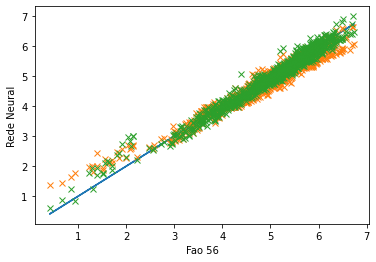

0.9473194145085808


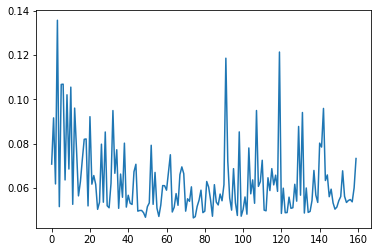

In [ ]:
modelo.compare(1000,True)

plt.plot(history.history['val_loss'])
plt.show()

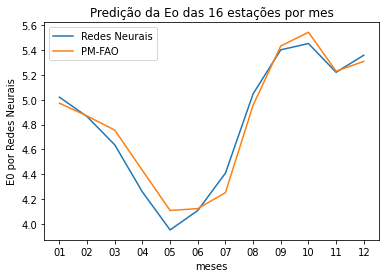

0.9621110066847361

In [ ]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))